In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from pathlib import Path
import torch
import pickle
import os, os.path

from modules import optimize_ML
from modules.elbo import ELBO

### Run curvature estimation for 100 different trajectories to test recovery 

In [ ]:
sim_idx = 0 # which out of the 100 simulated trajectories to use
n_traj = 50
n_bootstrap = 20
data_path = Path('data')

c_true = np.empty((n_traj, n_bootstrap)) # simulated global curvature
c_true[:] = np.nan

c_est = np.empty((n_traj, n_bootstrap))  # average estimated local curvature
c_est[:] = np.nan

_, _, files = next(os.walk(Path('data') / 'curvatures'))
n_files = len(files)


for i in range(n_traj):

    if not i % 5:
        print(f"Trajectory: {i}")

    rand_file = np.random.randint(1, n_files)
    for j in range(n_bootstrap):
        try:
            print(f"Bootstrap: {j}")
            # load data
            # f_name = f'sim_{str(i+1).zfill(4)}.mat'
            f_name = f'sim_{str(rand_file).zfill(4)}.mat'
            S = spio.loadmat(Path(data_path) / f_name)['S']
            S_list = [S[0, il] for il in range(S.shape[1])]  # convert to list of structs
            c_true[i, j] = np.mean(np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten())
            
            # unpack data
            np.fill_diagonal(S_list[sim_idx]['Pc_reshaped'][0, 0], 0.5) # manually set diagonals to 0.5 (chance level if A=X=B)
            n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
            n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
            n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
            n_dim = 2

            elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=30000, verbose=False)
            x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, _ = elbo.optimize_ELBO_SGD()            
            c_est[i, j] = torch.mean(torch.rad2deg(elbo.mu_post_c)).detach().numpy()
        except:
            print(f"Bootstrap run {j} resulted in an error. Will be skipped for the analysis.")

    # save data 
    save_data = {'file_name': f_name,
                 'x_true': S_list[sim_idx]['x'][0, 0],
                 'x_pred': x, # currently only the last most likely trajectory is being saved
                 'perf_true': S_list[sim_idx]['Pc_reshaped'][0, 0],
                 'perf_pred': p.detach().squeeze(),
                 'c_true_sim': np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 
                 'c_post': c_est[i],
                 'c_true': c_true[i]}

    f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
    with open(f_name, 'wb') as f:
        pickle.dump(save_data, f)

Trajectory: 0
Bootstrap: 0
Bootstrap: 1
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Bootstrap: 0
Bootstrap run 0 resulted in an error. Will be skipped for the analysis.
Bootstrap: 1
Bootstrap run 1 resulted in an error. Will be skipped for the analysis.
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Bootstrap: 0
Bootstrap: 1
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap run 6 resulted in an error. Will be skipped for the analysis.
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap run 10 resulted in an error. Will be skipped for the analysis.
Bootstrap: 11

### Visualization

In [ ]:
# load data
c_true_all_trajs = np.zeros((n_traj, n_bootstrap))
c_post_all_trajs = np.zeros((n_traj, n_bootstrap))
for i in range(n_traj):
    f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
    with open(f_name, 'rb') as f:
        loaded_dict = pickle.load(f)
    c_true_all_trajs[i] = loaded_dict['c_true']
    c_post_all_trajs[i] = loaded_dict['c_post']

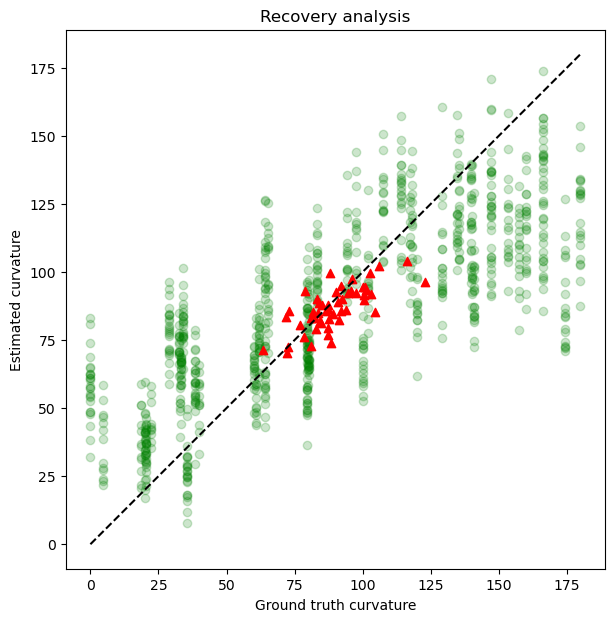

In [ ]:
fig1, ax = plt.subplots(figsize=(13, 7))

ax.scatter(c_true_all_trajs, c_post_all_trajs, c='green', alpha=0.2)
ax.scatter(np.nanmean(c_true_all_trajs, axis=1), np.nanmean(c_post_all_trajs, axis=1), marker='^', c='red', alpha=1)
ax.plot([0, 180], [0, 180], 'k--')
ax.set_title('Recovery analysis')
ax.set_xlabel('Ground truth curvature')
ax.set_ylabel('Estimated curvature')
ax.set_box_aspect(1)

plt.show()